# ResNet

Here I implemented a standard (though fairly shallow) conv-net architecture with the addition of [residual shortcuts](https://arxiv.org/abs/1512.03385).

In [1]:
import os

import numpy as np
from numpy.random import choice
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import transforms
from torchvision import datasets
import torchvision

import sys
sys.path.append('../utils')
sys.path.append('../models')
import utils
import res_net

In [2]:
data_dir = '../data'

# values for normalisation
channel_means = (0.5071, 0.4865, 0.4409)
channel_standard_devs = (0.2673, 0.2564, 0.2762)

transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(channel_means, channel_standard_devs)
])
batchsize=64

test_set = datasets.CIFAR100(data_dir, train=False, transform=transformation, download=True)
test_loader = DataLoader(test_set, batch_size=batchsize)

rest = datasets.CIFAR100(data_dir, train=True, transform=transformation, download=True)
train_loader, validation_loader = utils.train_validation_split(rest, fraction=0.1, batchsize=batchsize)

print(f'training batches: {len(train_loader)}')
print(f'validation batches: {len(validation_loader)}')
print(f'test batches: {len(test_loader)}')
print(f'batch size: {batchsize}')

Files already downloaded and verified
Files already downloaded and verified
training batches: 704
validation batches: 79
test batches: 157
batch size: 64


In [3]:
print('MODEL: ResNet')
net = res_net.ResNet()
print(f'parameters: {utils.count_parameters(net, in_millions=True):.2f} million\n')

optimizer = torch.optim.Adam(net.parameters(),
                             lr=0.001,
                             weight_decay=0.0001
                             )
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, factor=0.75, patience=5, threshold=0.01, verbose=True)

utils.train_model(net, train_loader, validation_loader, optimizer, scheduler, max_epoch=250)

MODEL: ResNet
parameters: 6.93 million

epoch	training-CE	validation-CE	validation-accuracy (%)
0	4.23		4.02		0.00
1	3.88		3.74		12.50
2	3.70		3.49		0.00
3	3.54		3.32		25.00
4	3.41		3.22		50.00
5	3.30		3.15		37.50
6	3.20		3.03		25.00
7	3.12		2.96		12.50
8	3.04		2.90		25.00
9	2.97		2.86		12.50
10	2.90		2.86		25.00
11	2.86		2.81		37.50
12	2.79		2.78		12.50
13	2.74		2.71		37.50
14	2.68		2.71		12.50
15	2.64		2.68		37.50
16	2.59		2.66		25.00
17	2.53		2.60		12.50
18	2.49		2.60		25.00
19	2.45		2.58		37.50
20	2.41		2.58		25.00
21	2.36		2.56		37.50
22	2.33		2.54		25.00
23	2.30		2.52		12.50
24	2.27		2.55		25.00
25	2.22		2.56		12.50
26	2.19		2.52		25.00
27	2.14		2.48		12.50
28	2.12		2.48		50.00
29	2.11		2.46		37.50
30	2.07		2.48		25.00
31	2.04		2.49		25.00
32	2.01		2.50		37.50
33	1.99		2.45		25.00
34	1.96		2.44		37.50
35	1.92		2.42		25.00
36	1.90		2.44		37.50
37	1.90		2.43		37.50
38	1.87		2.42		37.50
39	1.84		2.44		62.50
40	1.83		2.42		50.00
Epoch    41: reducing learning rate of group 0 to 7.500

... overfits massively

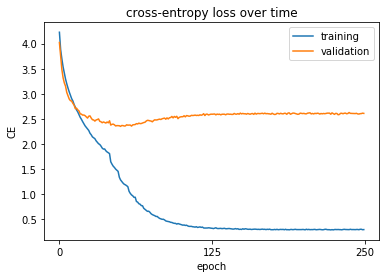


Evaluation on the test-set:
mean batch cross-entropy loss: 2.35
accuracy: 42.16


In [5]:
utils.plot_error_curves(utils.error_stats, error_name='cross-entropy loss')

net.load_state_dict(torch.load(f'{net.__class__.__name__}_best.pt'))
utils.test_set_evaluation(net.cuda(), test_loader, just_print=True)